# Creating a Pipeline from an SQL Query

The ```Pipeline``` class has an alternate method of instatiation that supports passing in data from an SQL query. 

The class method ```Pipeline.from_sql``` accepts a standard Python DB API connection object and a query, along with interpolated query parameters, and returns a ```Pipeline``` object that can be manipulated in the usual ways.

A utility function called ```connect_d3drdb``` returns a Connection handle for the DIII-D relational database server, d3drdb.gat.com, and by default opens the ```d3drdb``` database.

A minimal example is illustrated below:

In [67]:
from toksearch.sql.mssql import connect_d3drdb
from toksearch import Pipeline
import datetime

# Create a Connection object. By default, connect_d3drdb will look at the file ~/D3DRDB.sybase_login
# for your username username and password
conn = connect_d3drdb()

# Grab all plasma shots, sorted by shot number is ascending order
query = "select shot from shots_type where shot_type = 'plasma' order by shot asc"
pipeline = Pipeline.from_sql(conn, query)

results = pipeline.compute_serial()

print(f'NUM RESULTS: {len(results)}')

now = datetime.datetime.now()
print(f'Most recent plasma shot (as of {now.strftime("%Y-%m-%d")}): {results[-1]["shot"]}')

NUM RESULTS: 75615
Most recent plasma shot (as of 2020-12-17): 183872


# Connecting to the d3drdb from saga

All users on iris are given the file ~/D3DRDB.sybase_login when their accounts are created. This file contains the username and password for the d3drdb database. The best practice is to use read this file and grab the username and password from it, rather than putting them into source code. For usage on saga simply do this to copy the file:

```bash
#On saga:
scp iris:D3DRDB.sybase_login ~/
```

The default behavior of the ```connect_d3drdb``` utility function is to read this file, so if it is available, there is no need to supply the username or password keyword arguments.

# Using parameterized queries

The ```Pipeline.from_sql``` supports parameterized queries. The exact syntax for this varies depending on the particular database being used. Microsoft SQL Server, the underlying database management system for the d3drdb, for example, uses ```%d``` or ```%s``` as placeholders, either of which can be used interchangeably no matter the variable type. SQLite, by contrast, uses ```?``` as the placeholder.

The example below modifies the query in the previous example to use a parameter.

In [68]:
parameterized_query = """
    select shot 
    from shots_type 
    where shot_type = 'plasma' and shot > %d
    order by shot asc
    """
minimum_shot = 180000
pipeline = Pipeline.from_sql(conn, parameterized_query, minimum_shot)
results = pipeline.compute_serial()
print(f'NUM_RESULTS: {len(results)}')
assert results[0]['shot'] > minimum_shot

NUM_RESULTS: 1730


# Query Restrictions

There are some restrictions on the query that is passed to the ```Pipeline.from_sql``` method.

* The results of the query must contain the column "shots". If not, an exception will be raised. 

In [69]:
good_query = "select shot, entered from shots where shot > 183800"
good_pipeline = Pipeline.from_sql(conn, good_query)
results = good_pipeline.compute_serial()
print(f'No exception raised using good query!')
print(f'Sample result: {results[0]}')
    
bad_query = "select entered from shots where shot > 183800"
try:
    bad_pipeline = Pipeline.from_sql(conn, bad_query)
except Exception as e:
    print(f'\n\nException raised with bad_query: {e}')
    

No exception raised using good query!
Sample result: {'shot': 183801, 'errors': {}, 'entered': datetime.datetime(2020, 12, 3, 15, 5, 51, 253000)}


Exception raised with bad_query: Cannot create Record without a shot number


* The strings 'key' and 'errors' are reserved words and cannot be used as column names.

In [70]:
another_bad_query = "select shot, entered as 'key' from shots where shot > 183800"
try:
    bad_pipeline = Pipeline.from_sql(conn, another_bad_query)
except Exception as e:
    print(f'Exception raised with another_bad_query: {e}')



Exception raised with another_bad_query: Illegal field: key when trying to create Record


* All columns must be named.

In [71]:
good_query = "select shot, 'some_constant' as a_constant from shots where shot > 183800"
good_pipeline = Pipeline.from_sql(conn, good_query)
results = good_pipeline.compute_serial()
print(f'No exception raised using good query!')
print(f'Sample result: {results[0]}')

anonymous_query = "select shot, 'some_constant' from shots where shot > 183800"
try:
    bad_pipeline = Pipeline.from_sql(conn, anonymous_query)
except Exception as e:
    print(f'\n\nException raised with anonymous_query: {e}')

No exception raised using good query!
Sample result: {'shot': 183801, 'errors': {}, 'a_constant': 'some_constant'}


Exception raised with anonymous_query: Cannot use anonymous field names


# Additional ```connect_d3drdb``` Options

By default, if the password keyword argument is not set, then the username and password are read from the file specified in the password_file keyword argument (which by default is set to ~/D3DRDB.sybase_login).

The host, port, and db name can all be changed. 

For example, to use the confinement database:


In [72]:
confinement_conn = connect_d3drdb(db='confinement')

confinement_query = "select shot, ip from confinement"
confinement_pipeline = Pipeline.from_sql(confinement_conn, confinement_query)

print(f'One record: {confinement_pipeline.compute_serial()[-1]}')


One record: {'shot': 172579, 'errors': {}, 'ip': 1.14127}


The following shows the complete set of options for ```connect_d3drdb```:

In [73]:
help(connect_d3drdb)

Help on function connect_d3drdb in module toksearch.sql.mssql:

connect_d3drdb(username='sammuli', password=None, host='d3drdb.gat.com', db='d3drdb', port=8001, password_file='/home/sammuli/D3DRDB.sybase_login')
    Connect to the d3drdb 
    
    Keyword Parameters:
        host (str): Defaults to 'd3drdb.gat.com'
        port (int): Defaults to 8001
        db (str): Name of the db (e.g. d3drdb, confinement). Defaults to d3drdb
        username (str): Defaults to current user
        password (str): Defaults to None. If not set, an attempt will be made
            to read a password file
       password_file (str): Full path the a password file, formatted with
            username on the first line and password on the second line.
    
    Returns:
        Python DB API compliant Connection object
    
    Can be used to return a Connection object directly, or used
    as a context manager.
    Examples:
       conn = connect_d3drdb()
    
       with connect_d3drdb() as conn:
      

# A fancier example

The following is a more complete example of using SQL in conjunction with TokSearch.

The idea is to grab the flattop start time and duration from the d3drdb summaries table for all plasma shots since shot 183000. Then we'll fetch the full ip signal for those shots and plot ip with the flat top bounds for one of the shots.

BATCH 1/1
NUM PARTITIONS: 534
MEDIAN PARTITION SIZE: 1
###########
NUM RESULTS: 514


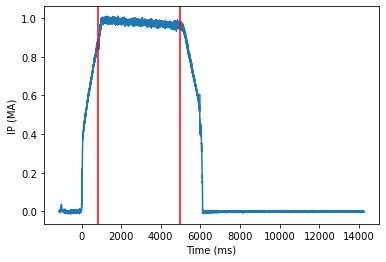

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

from toksearch import PtDataSignal

fancy_query = """
    select shots_type.shot, summaries.t_ip_flat as t_start, summaries.ip_flat_duration as t_delta
    from shots_type, summaries
    where shots_type.shot_type = 'plasma' and shots_type.shot = summaries.shot and shots_type.shot > %d
    """

minimum_shot = 183000

# Use the context managaer mode for connect_d3drdb. That was the connection will be cleaned up automatically
with connect_d3drdb() as conn:
    pipeline = Pipeline.from_sql(conn, fancy_query, minimum_shot)

pipeline.fetch('ip', PtDataSignal('ip'))

# Just throw away shots with errors
@pipeline.where
def no_errors(rec):
    return not rec.errors
    
# Use ray to get the results in parallel
results = pipeline.compute_ray(numparts=1000)

print(f'###########\nNUM RESULTS: {len(results)}')

# Grab a single record
rec = results[-1]

# Plot stuff
fig, ax = plt.subplots()
shot = rec['shot']
data = rec['ip']['data']
times = rec['ip']['times']
flattop_start = rec['t_start']
flattop_end = flattop_start + rec['t_delta']

ax.plot(times, data*1e-6)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IP (MA)')

ax.axvline(flattop_start, color='r')
ax.axvline(flattop_end, color='r')
